In [2]:
import torch
from torch import nn
from torchvision.transforms import v2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm
import cv2
import numpy as np

In [3]:
#Importing pyspark.sql for loading the parquet files into a spark dataframe
from pyspark.sql import SparkSession

# Creating a spark session
spark = SparkSession.builder \
    .appName("DatasetCreator") \
    .getOrCreate()

# Loading the parquet files from the directory
parquet_files_path = "/kaggle/input/quark-gluon"
df = spark.read.parquet(parquet_files_path)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 11:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Number of rows to select to train and test the model at a time
num_rows = 1500

In [5]:
#Sampling random n rows from the dataset
df = df.sample(withReplacement=False, fraction=num_rows/df.count())

In [6]:
#Converting df into a pandas dataframe
df = df.toPandas()

In [7]:
#Dividing the dataset into train and test set
spark.stop()

### Processing the Data :-
#### 1. Dividing the data into train and test sets
#### 2. Creating a pytorch Dataset and a Dataloader

In [8]:
X = df.drop('y', axis=1)
y = df['y']

# Splitting the data into train and test sets with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Cropping each of the channel of the image into 9 equal parts and stacking them to create a total
of 30 channels**

In [9]:
def multichanneliser(image):
    # Loading the RGB image
    image = image.reshape((125, 125, 3))

    # Splitting the image into its RGB channels
    b, g, r = cv2.split(image)

    # Determining the dimensions of each part
    height, width, _ = image.shape
    part_height = height // 3
    part_width = width // 3

    # Initializing lists to store the parts of each channel
    b_parts = []
    g_parts = []
    r_parts = []

    # Cropping each channel into 9 equal parts
    for i in range(3):
        for j in range(3):
            # Calculating the cropping boundaries
            y_start = i * part_height
            y_end = (i + 1) * part_height
            x_start = j * part_width
            x_end = (j + 1) * part_width

            # Crop each channel
            b_part = b[y_start:y_end, x_start:x_end]
            g_part = g[y_start:y_end, x_start:x_end]
            r_part = r[y_start:y_end, x_start:x_end]

            # Resize each part to match the dimensions of the original RGB channels
            b_part_resized = cv2.resize(b_part, (width, height))
            g_part_resized = cv2.resize(g_part, (width, height))
            r_part_resized = cv2.resize(r_part, (width, height))

            # Append the resized parts to the respective lists
            b_parts.append(b_part_resized)
            g_parts.append(g_part_resized)
            r_parts.append(r_part_resized)

    # Stacking the parts of each channel together to create 9 channels
    b_stacked = np.stack(b_parts, axis=-1)
    g_stacked = np.stack(g_parts, axis=-1)
    r_stacked = np.stack(r_parts, axis=-1)

    # Combining all channels into a single multi-channel image
    all_channels = np.dstack((b, g, r, b_stacked, g_stacked, r_stacked))

    return all_channels

In [10]:
import torch
from torchvision.transforms import v2
import numpy as np
from torch.utils.data import Dataset, DataLoader

#Creating a custom Pytorch Dataset
class QGDataset(Dataset):
    def __init__(self, X, y, transform=False):
        self.X = X
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        image = torch.tensor(self.X['X_jets'].iloc[idx])

        if self.transform:
            #image = v2.RandomRotation(degrees=[-90, 90])(image)
            #image = v2.RandomVerticalFlip(p=0.6)(image)
            image = v2.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])(image)

        image = image.numpy()

        image = torch.tensor(multichanneliser(image)).reshape((30, 125, 125))
        image = image.to(torch.float32)

        label = self.y.iloc[idx]

        return image, label

# Train and Test pytorch Datasets

train_dataset = QGDataset(X_train, y_train, True)
test_dataset= QGDataset(X_test, y_test)

#Defining the batch size
BATCH_SIZE = 32
# Train and test pytorch Dataloaders

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,  shuffle=False)

## Creating the VGG-12 architecture :-
#### https://arxiv.org/pdf/1409.1556.pdf
#### The architecture of VGG-12 is as follows :-
#### 10 layers in 4 stacks are convolutional layers and 2 layers are linear classification layers :-
##### 1.)  First stack :- 2 conv. layers each with out_channels 64
##### 2.) Second Stack :- 2 conv. layers each with out_channels 128
##### 3.) Third Stack :- 3 conv. layers each with out_channels 256
##### 4.) Fourth Stack :- 3 conv.layers each with out_channels 256

In [11]:
VGG12 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 256, 256, 256, 'M']
class VGGNet(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        self.in_channels = in_channels
        self.conv_layers = self.create_conv_layers(VGG12)

        self.fcs = nn.Sequential(
            nn.Linear(1024, 4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fcs(x)
        return x

    def create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == int:
                out_channels = x

                layers += [
                    nn.Conv2d(
                        in_channels=in_channels,
                        out_channels=out_channels,
                        kernel_size=(5, 5),
                        stride=(1, 1),
                        padding=(1, 1),
                    ),
                    nn.BatchNorm2d(x),
                    nn.ReLU(),
                ]
                in_channels = x
            elif x == "M":
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

        return nn.Sequential(*layers)

#### Creating the model

In [12]:
#Creating the model :-
model = VGGNet(in_channels=30, num_classes=1)

#### Setting the device and transferring the model to it

In [13]:
device = "cuda" if torch.cuda.is_available else 'cpu'

In [14]:
model.to(device)

VGGNet(
  (conv_layers): Sequential(
    (0): Conv2d(30, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(5, 5),

#### Defining the loss function and the optimizer

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

#### Training and Testing the model

In [16]:
# training loop

def train(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    return train_loss / len(train_loader.dataset)

In [17]:
# evaluation loop
def evaluate(model, data_loader, device):
    model.eval()
    y_true = []
    y_scores = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            y_true.extend(targets.cpu().numpy())
            y_scores.extend(outputs.cpu().numpy())
    return roc_auc_score(y_true, y_scores)

### Early stopping criteria
##### maxPatience : denotes the maximum patience for monotonic increase in validation loss while the     train loss dicreases.
##### maxTolerance : denotes the maximum patience for increase in validation loss after certain epoch. this increase doesn't have to be strictly monotonic

In [18]:
#best_auc
best_auc = 0.0

In [22]:
epochs = 20
# Setting maximum patience for early stopping
maxPatience = 12
maxTolerance = 12

# Initialize variables for early stopping and plotting
currentPatience = 0
currentTolerance = 0
toleranceValidScore = -1

# Training loop
for epoch in range(1, epochs + 1):
    print("Epoch {}/{}".format(epoch, epochs))
    train_loss = train(model, criterion, optimizer, train_dataloader, device)
    test_auc = evaluate(model, test_dataloader, device)
    
    print("Train Loss: {:.4f}, Test ROC-AUC: {:.4f}".format(train_loss, test_auc))
    
    # Update patience and tolerance
    if test_auc <= toleranceValidScore:
        currentTolerance += 1
    else:
        currentTolerance = 0
        toleranceValidScore = test_auc
    
    if currentTolerance == maxTolerance:
        print("Early stopping training due to overfitting...")
        break
    
    # Save checkpoint
    if test_auc > best_auc:
        best_auc = test_auc
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saving model checkpoint...")
    
    # Update patience for early stopping
    if test_auc <= best_auc:
        currentPatience += 1
    else:
        currentPatience = 0
    
    if currentPatience == maxPatience:
        print("Early stopping training due to overfitting...")
        break

print("Training completed!")

Epoch 1/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5689, Test ROC-AUC: 0.6673
Epoch 2/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5809, Test ROC-AUC: 0.6723
Epoch 3/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.6062, Test ROC-AUC: 0.6723
Epoch 4/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5726, Test ROC-AUC: 0.6846
Saving model checkpoint...
Epoch 5/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5684, Test ROC-AUC: 0.6712
Epoch 6/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5938, Test ROC-AUC: 0.6726
Epoch 7/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5679, Test ROC-AUC: 0.5984
Epoch 8/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5617, Test ROC-AUC: 0.6810
Epoch 9/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5461, Test ROC-AUC: 0.6158
Epoch 10/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5309, Test ROC-AUC: 0.5132
Epoch 11/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5419, Test ROC-AUC: 0.6488
Epoch 12/20


  0%|          | 0/39 [00:00<?, ?it/s]

Train Loss: 0.5269, Test ROC-AUC: 0.5826
Early stopping training due to overfitting...
Training completed!


#### Evaluating

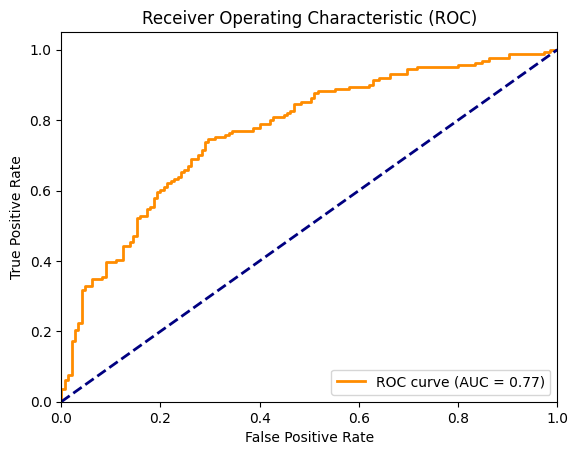

In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Evaluating the best model on test data
best_model = VGGNet(in_channels=30, num_classes=1).to(device)
best_model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
y_true = []
y_scores = []
with torch.no_grad():
    for inputs, targets in test_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = best_model(inputs)
        y_true.extend(targets.cpu().numpy())
        y_scores.extend(outputs.cpu().numpy())

# Calculating ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

#### Model Weights

In [24]:
model.state_dict()

OrderedDict([('conv_layers.0.weight',
              tensor([[[[-1.3093e-02,  3.3334e-02,  3.1927e-02, -2.6101e-03, -2.7409e-02],
                        [-3.9930e-02, -3.6771e-02,  1.3354e-02, -5.4537e-02, -2.1199e-02],
                        [ 1.3333e-02,  2.4253e-02,  3.0798e-04, -2.4024e-02, -5.3689e-02],
                        [-4.8205e-04,  6.2482e-02, -4.3007e-02, -5.1958e-02,  2.6945e-03],
                        [-3.0340e-02,  8.3732e-02,  1.4160e-03, -5.6788e-02,  1.2489e-01]],
              
                       [[ 2.5961e-02,  9.4327e-03,  2.6122e-02,  7.0639e-02, -6.9037e-03],
                        [ 1.3089e-01,  8.5601e-02, -7.5794e-03,  6.8504e-02,  9.0164e-02],
                        [ 3.3455e-02,  7.5546e-02,  8.0308e-02,  8.8887e-02,  2.4040e-02],
                        [ 3.2897e-02,  7.5089e-02,  8.7922e-03,  1.0652e-01,  2.6424e-02],
                        [ 8.6503e-02,  8.8615e-02,  8.9914e-02,  7.5592e-02,  1.8905e-03]],
              
                    